# AE_VAE_GAN_CAAE

## Описание задачи

В рамках подготовки к докладу 30.01.2020 рассмотреть следующие архитектуры AE, VAE, GAN, CAAE. В результате получить визуализацию обучения всех 4 моделей

Dataset: MNIST

### import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist_2, plot_mnist_4
import numpy as np
import os

%matplotlib inline

### local utils

## Make Nets and run models

### AE

Автокодировщики - нейронные сети для задачи unsupervised learning (не совсем), где входы являются предиктом для выхода.

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform, batch_size=64)

In [4]:
from models.AE import AE

model_AE_16 = AE(16)
model_AE_32 = AE(32)
model_AE_64 = AE(64)


# models = {'16': model_AE_16, '32': model_AE_32, '64': model_AE_64}
models = {'64': model_AE_64}
rho = 1e-5
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [5]:
def train(epochs, models, log=None):
    train_size = len(train_loader.sampler)
    # запустим data loader (загрузчик)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data) + rho*F.l1_loss(model.encode(data.view(-1, 28*28)),
                                                                   target=torch.zeros_like(model.encode(data.view(-1, 28*28))), 
                                                                   size_average=False)
            #F.l1_loss(data.view(-1, 784), output)  # l1-loss
            loss.backward()
            model.optim.step()
        
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
        else:
            batch_idx += 1
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            if log is not None:
                for k in models:
                    log[k].append((models[k]._loss, models[k]._rho_loss))
            print(line + losses)
        
        
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'pho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    pho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                pho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        pho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], pho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], pho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [6]:
for epoch in range(1, 6):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 1 [0/50000 (0%)]	Losses 64: 0.987744
Train Epoch: 1 [128/50000 (0%)]	Losses 64: 0.969238
Train Epoch: 1 [192/50000 (0%)]	Losses 64: 0.961338
Train Epoch: 1 [256/50000 (1%)]	Losses 64: 0.945535
Train Epoch: 1 [320/50000 (1%)]	Losses 64: 0.939713
Train Epoch: 1 [384/50000 (1%)]	Losses 64: 0.924400
Train Epoch: 1 [448/50000 (1%)]	Losses 64: 0.918981
Train Epoch: 1 [512/50000 (1%)]	Losses 64: 0.909558
Train Epoch: 1 [576/50000 (1%)]	Losses 64: 0.900865
Train Epoch: 1 [640/50000 (1%)]	Losses 64: 0.900207
Train Epoch: 1 [704/50000 (1%)]	Losses 64: 0.888681
Train Epoch: 1 [768/50000 (2%)]	Losses 64: 0.883933
Train Epoch: 1 [832/50000 (2%)]	Losses 64: 0.875966
Train Epoch: 1 [896/50000 (2%)]	Losses 64: 0.871636
Train Epoch: 1 [960/50000 (2%)]	Losses 64: 0.866825
Train Epoch: 1 [1024/50000 (2%)]	Losses 64: 0.860556
Train Epoch: 1 [1088/50000 (2%)]	Losses 64: 0.854693
Train Epoch: 1 [1152/50000 (2%)]	Losses 64: 0.850053
Train Epoch: 1 [1216/50000 (2%)]	Losses 64: 0.847214
Train Epoc

Train Epoch: 1 [10304/50000 (21%)]	Losses 64: 0.351683
Train Epoch: 1 [10368/50000 (21%)]	Losses 64: 0.347031
Train Epoch: 1 [10432/50000 (21%)]	Losses 64: 0.337809
Train Epoch: 1 [10496/50000 (21%)]	Losses 64: 0.329713
Train Epoch: 1 [10560/50000 (21%)]	Losses 64: 0.332744
Train Epoch: 1 [10624/50000 (21%)]	Losses 64: 0.337244
Train Epoch: 1 [10688/50000 (21%)]	Losses 64: 0.350438
Train Epoch: 1 [10752/50000 (21%)]	Losses 64: 0.347164
Train Epoch: 1 [10816/50000 (22%)]	Losses 64: 0.342977
Train Epoch: 1 [10880/50000 (22%)]	Losses 64: 0.334934
Train Epoch: 1 [10944/50000 (22%)]	Losses 64: 0.331415
Train Epoch: 1 [11008/50000 (22%)]	Losses 64: 0.329063
Train Epoch: 1 [11072/50000 (22%)]	Losses 64: 0.345167
Train Epoch: 1 [11136/50000 (22%)]	Losses 64: 0.325037
Train Epoch: 1 [11200/50000 (22%)]	Losses 64: 0.325761
Train Epoch: 1 [11264/50000 (23%)]	Losses 64: 0.326978
Train Epoch: 1 [11328/50000 (23%)]	Losses 64: 0.350876
Train Epoch: 1 [11392/50000 (23%)]	Losses 64: 0.331504
Train Epoc

Train Epoch: 1 [20288/50000 (41%)]	Losses 64: 0.293507
Train Epoch: 1 [20352/50000 (41%)]	Losses 64: 0.285610
Train Epoch: 1 [20416/50000 (41%)]	Losses 64: 0.288034
Train Epoch: 1 [20480/50000 (41%)]	Losses 64: 0.294040
Train Epoch: 1 [20544/50000 (41%)]	Losses 64: 0.286119
Train Epoch: 1 [20608/50000 (41%)]	Losses 64: 0.281163
Train Epoch: 1 [20672/50000 (41%)]	Losses 64: 0.278614
Train Epoch: 1 [20736/50000 (41%)]	Losses 64: 0.295359
Train Epoch: 1 [20800/50000 (42%)]	Losses 64: 0.290701
Train Epoch: 1 [20864/50000 (42%)]	Losses 64: 0.273514
Train Epoch: 1 [20928/50000 (42%)]	Losses 64: 0.283701
Train Epoch: 1 [20992/50000 (42%)]	Losses 64: 0.290627
Train Epoch: 1 [21056/50000 (42%)]	Losses 64: 0.297878
Train Epoch: 1 [21120/50000 (42%)]	Losses 64: 0.261800
Train Epoch: 1 [21184/50000 (42%)]	Losses 64: 0.291380
Train Epoch: 1 [21248/50000 (42%)]	Losses 64: 0.266933
Train Epoch: 1 [21312/50000 (43%)]	Losses 64: 0.284589
Train Epoch: 1 [21376/50000 (43%)]	Losses 64: 0.281268
Train Epoc

Train Epoch: 1 [30528/50000 (61%)]	Losses 64: 0.264191
Train Epoch: 1 [30592/50000 (61%)]	Losses 64: 0.264139
Train Epoch: 1 [30656/50000 (61%)]	Losses 64: 0.259469
Train Epoch: 1 [30720/50000 (61%)]	Losses 64: 0.265845
Train Epoch: 1 [30784/50000 (62%)]	Losses 64: 0.252531
Train Epoch: 1 [30848/50000 (62%)]	Losses 64: 0.269337
Train Epoch: 1 [30912/50000 (62%)]	Losses 64: 0.281483
Train Epoch: 1 [30976/50000 (62%)]	Losses 64: 0.266475
Train Epoch: 1 [31040/50000 (62%)]	Losses 64: 0.258107
Train Epoch: 1 [31104/50000 (62%)]	Losses 64: 0.247750
Train Epoch: 1 [31168/50000 (62%)]	Losses 64: 0.248530
Train Epoch: 1 [31232/50000 (62%)]	Losses 64: 0.281434
Train Epoch: 1 [31296/50000 (63%)]	Losses 64: 0.267508
Train Epoch: 1 [31360/50000 (63%)]	Losses 64: 0.265379
Train Epoch: 1 [31424/50000 (63%)]	Losses 64: 0.265442
Train Epoch: 1 [31488/50000 (63%)]	Losses 64: 0.275681
Train Epoch: 1 [31552/50000 (63%)]	Losses 64: 0.273319
Train Epoch: 1 [31616/50000 (63%)]	Losses 64: 0.268765
Train Epoc

Train Epoch: 1 [41216/50000 (82%)]	Losses 64: 0.256148
Train Epoch: 1 [41280/50000 (82%)]	Losses 64: 0.243871
Train Epoch: 1 [41344/50000 (83%)]	Losses 64: 0.253684
Train Epoch: 1 [41408/50000 (83%)]	Losses 64: 0.241765
Train Epoch: 1 [41472/50000 (83%)]	Losses 64: 0.246620
Train Epoch: 1 [41536/50000 (83%)]	Losses 64: 0.250099
Train Epoch: 1 [41600/50000 (83%)]	Losses 64: 0.237862
Train Epoch: 1 [41664/50000 (83%)]	Losses 64: 0.248201
Train Epoch: 1 [41728/50000 (83%)]	Losses 64: 0.240227
Train Epoch: 1 [41792/50000 (84%)]	Losses 64: 0.248317
Train Epoch: 1 [41856/50000 (84%)]	Losses 64: 0.246993
Train Epoch: 1 [41920/50000 (84%)]	Losses 64: 0.247771
Train Epoch: 1 [41984/50000 (84%)]	Losses 64: 0.230595
Train Epoch: 1 [42048/50000 (84%)]	Losses 64: 0.250389
Train Epoch: 1 [42112/50000 (84%)]	Losses 64: 0.242405
Train Epoch: 1 [42176/50000 (84%)]	Losses 64: 0.240993
Train Epoch: 1 [42240/50000 (84%)]	Losses 64: 0.255160
Train Epoch: 1 [42304/50000 (85%)]	Losses 64: 0.239909
Train Epoc

Train Epoch: 2 [1216/50000 (2%)]	Losses 64: 0.229187
Train Epoch: 2 [1280/50000 (3%)]	Losses 64: 0.234937
Train Epoch: 2 [1344/50000 (3%)]	Losses 64: 0.223126
Train Epoch: 2 [1408/50000 (3%)]	Losses 64: 0.232698
Train Epoch: 2 [1472/50000 (3%)]	Losses 64: 0.221871
Train Epoch: 2 [1536/50000 (3%)]	Losses 64: 0.235234
Train Epoch: 2 [1600/50000 (3%)]	Losses 64: 0.236691
Train Epoch: 2 [1664/50000 (3%)]	Losses 64: 0.225488
Train Epoch: 2 [1728/50000 (3%)]	Losses 64: 0.222870
Train Epoch: 2 [1792/50000 (4%)]	Losses 64: 0.228787
Train Epoch: 2 [1856/50000 (4%)]	Losses 64: 0.210309
Train Epoch: 2 [1920/50000 (4%)]	Losses 64: 0.237424
Train Epoch: 2 [1984/50000 (4%)]	Losses 64: 0.232976
Train Epoch: 2 [2048/50000 (4%)]	Losses 64: 0.213765
Train Epoch: 2 [2112/50000 (4%)]	Losses 64: 0.231670
Train Epoch: 2 [2176/50000 (4%)]	Losses 64: 0.228858
Train Epoch: 2 [2240/50000 (4%)]	Losses 64: 0.227835
Train Epoch: 2 [2304/50000 (5%)]	Losses 64: 0.218201
Train Epoch: 2 [2368/50000 (5%)]	Losses 64: 0.

Train Epoch: 2 [12032/50000 (24%)]	Losses 64: 0.203997
Train Epoch: 2 [12096/50000 (24%)]	Losses 64: 0.200112
Train Epoch: 2 [12160/50000 (24%)]	Losses 64: 0.207119
Train Epoch: 2 [12224/50000 (24%)]	Losses 64: 0.210739
Train Epoch: 2 [12288/50000 (25%)]	Losses 64: 0.212239
Train Epoch: 2 [12352/50000 (25%)]	Losses 64: 0.208007
Train Epoch: 2 [12416/50000 (25%)]	Losses 64: 0.215140
Train Epoch: 2 [12480/50000 (25%)]	Losses 64: 0.198463
Train Epoch: 2 [12544/50000 (25%)]	Losses 64: 0.200733
Train Epoch: 2 [12608/50000 (25%)]	Losses 64: 0.211279
Train Epoch: 2 [12672/50000 (25%)]	Losses 64: 0.197836
Train Epoch: 2 [12736/50000 (25%)]	Losses 64: 0.215544
Train Epoch: 2 [12800/50000 (26%)]	Losses 64: 0.212201
Train Epoch: 2 [12800/50000 (26%)]	Losses 64: 0.204267
Train Epoch: 2 [12928/50000 (26%)]	Losses 64: 0.225353
Train Epoch: 2 [12992/50000 (26%)]	Losses 64: 0.216363
Train Epoch: 2 [13056/50000 (26%)]	Losses 64: 0.209740
Train Epoch: 2 [13120/50000 (26%)]	Losses 64: 0.228426
Train Epoc

Train Epoch: 2 [21632/50000 (43%)]	Losses 64: 0.187740
Train Epoch: 2 [21696/50000 (43%)]	Losses 64: 0.199863
Train Epoch: 2 [21760/50000 (43%)]	Losses 64: 0.202051
Train Epoch: 2 [21824/50000 (44%)]	Losses 64: 0.196879
Train Epoch: 2 [21888/50000 (44%)]	Losses 64: 0.193145
Train Epoch: 2 [21952/50000 (44%)]	Losses 64: 0.203741
Train Epoch: 2 [22016/50000 (44%)]	Losses 64: 0.192085
Train Epoch: 2 [22080/50000 (44%)]	Losses 64: 0.181665
Train Epoch: 2 [22144/50000 (44%)]	Losses 64: 0.198767
Train Epoch: 2 [22208/50000 (44%)]	Losses 64: 0.184334
Train Epoch: 2 [22272/50000 (45%)]	Losses 64: 0.191554
Train Epoch: 2 [22336/50000 (45%)]	Losses 64: 0.196823
Train Epoch: 2 [22400/50000 (45%)]	Losses 64: 0.197794
Train Epoch: 2 [22464/50000 (45%)]	Losses 64: 0.188003
Train Epoch: 2 [22528/50000 (45%)]	Losses 64: 0.183082
Train Epoch: 2 [22592/50000 (45%)]	Losses 64: 0.198568
Train Epoch: 2 [22656/50000 (45%)]	Losses 64: 0.195105
Train Epoch: 2 [22720/50000 (45%)]	Losses 64: 0.200214
Train Epoc

Train Epoch: 2 [31168/50000 (62%)]	Losses 64: 0.198656
Train Epoch: 2 [31232/50000 (62%)]	Losses 64: 0.180335
Train Epoch: 2 [31296/50000 (63%)]	Losses 64: 0.186255
Train Epoch: 2 [31360/50000 (63%)]	Losses 64: 0.174993
Train Epoch: 2 [31424/50000 (63%)]	Losses 64: 0.190068
Train Epoch: 2 [31488/50000 (63%)]	Losses 64: 0.184050
Train Epoch: 2 [31552/50000 (63%)]	Losses 64: 0.185044
Train Epoch: 2 [31616/50000 (63%)]	Losses 64: 0.177077
Train Epoch: 2 [31680/50000 (63%)]	Losses 64: 0.190167
Train Epoch: 2 [31744/50000 (63%)]	Losses 64: 0.173344
Train Epoch: 2 [31808/50000 (64%)]	Losses 64: 0.189415
Train Epoch: 2 [31872/50000 (64%)]	Losses 64: 0.180547
Train Epoch: 2 [31936/50000 (64%)]	Losses 64: 0.182251
Train Epoch: 2 [32000/50000 (64%)]	Losses 64: 0.192592
Train Epoch: 2 [32064/50000 (64%)]	Losses 64: 0.189921
Train Epoch: 2 [32128/50000 (64%)]	Losses 64: 0.187261
Train Epoch: 2 [32192/50000 (64%)]	Losses 64: 0.188459
Train Epoch: 2 [32256/50000 (64%)]	Losses 64: 0.171730
Train Epoc

Train Epoch: 2 [40768/50000 (81%)]	Losses 64: 0.174310
Train Epoch: 2 [40832/50000 (82%)]	Losses 64: 0.173539
Train Epoch: 2 [40896/50000 (82%)]	Losses 64: 0.182380
Train Epoch: 2 [40960/50000 (82%)]	Losses 64: 0.168269
Train Epoch: 2 [41024/50000 (82%)]	Losses 64: 0.177535
Train Epoch: 2 [41088/50000 (82%)]	Losses 64: 0.167880
Train Epoch: 2 [41152/50000 (82%)]	Losses 64: 0.168081
Train Epoch: 2 [41216/50000 (82%)]	Losses 64: 0.173824
Train Epoch: 2 [41280/50000 (82%)]	Losses 64: 0.165404
Train Epoch: 2 [41344/50000 (83%)]	Losses 64: 0.174623
Train Epoch: 2 [41408/50000 (83%)]	Losses 64: 0.167318
Train Epoch: 2 [41472/50000 (83%)]	Losses 64: 0.168997
Train Epoch: 2 [41536/50000 (83%)]	Losses 64: 0.165018
Train Epoch: 2 [41600/50000 (83%)]	Losses 64: 0.165329
Train Epoch: 2 [41664/50000 (83%)]	Losses 64: 0.168435
Train Epoch: 2 [41728/50000 (83%)]	Losses 64: 0.168455
Train Epoch: 2 [41792/50000 (84%)]	Losses 64: 0.171677
Train Epoch: 2 [41856/50000 (84%)]	Losses 64: 0.168727
Train Epoc

Train Epoch: 3 [1216/50000 (2%)]	Losses 64: 0.160603
Train Epoch: 3 [1280/50000 (3%)]	Losses 64: 0.166403
Train Epoch: 3 [1344/50000 (3%)]	Losses 64: 0.168099
Train Epoch: 3 [1408/50000 (3%)]	Losses 64: 0.166213
Train Epoch: 3 [1472/50000 (3%)]	Losses 64: 0.162740
Train Epoch: 3 [1536/50000 (3%)]	Losses 64: 0.166905
Train Epoch: 3 [1600/50000 (3%)]	Losses 64: 0.162733
Train Epoch: 3 [1664/50000 (3%)]	Losses 64: 0.166922
Train Epoch: 3 [1728/50000 (3%)]	Losses 64: 0.162670
Train Epoch: 3 [1792/50000 (4%)]	Losses 64: 0.158748
Train Epoch: 3 [1856/50000 (4%)]	Losses 64: 0.159296
Train Epoch: 3 [1920/50000 (4%)]	Losses 64: 0.163629
Train Epoch: 3 [1984/50000 (4%)]	Losses 64: 0.173015
Train Epoch: 3 [2048/50000 (4%)]	Losses 64: 0.167908
Train Epoch: 3 [2112/50000 (4%)]	Losses 64: 0.147219
Train Epoch: 3 [2176/50000 (4%)]	Losses 64: 0.159765
Train Epoch: 3 [2240/50000 (4%)]	Losses 64: 0.159926
Train Epoch: 3 [2304/50000 (5%)]	Losses 64: 0.165555
Train Epoch: 3 [2368/50000 (5%)]	Losses 64: 0.

Train Epoch: 3 [12160/50000 (24%)]	Losses 64: 0.154403
Train Epoch: 3 [12224/50000 (24%)]	Losses 64: 0.145096
Train Epoch: 3 [12288/50000 (25%)]	Losses 64: 0.159577
Train Epoch: 3 [12352/50000 (25%)]	Losses 64: 0.163739
Train Epoch: 3 [12416/50000 (25%)]	Losses 64: 0.161525
Train Epoch: 3 [12480/50000 (25%)]	Losses 64: 0.151609
Train Epoch: 3 [12544/50000 (25%)]	Losses 64: 0.165651
Train Epoch: 3 [12608/50000 (25%)]	Losses 64: 0.151691
Train Epoch: 3 [12672/50000 (25%)]	Losses 64: 0.160037
Train Epoch: 3 [12736/50000 (25%)]	Losses 64: 0.151469
Train Epoch: 3 [12800/50000 (26%)]	Losses 64: 0.146136
Train Epoch: 3 [12800/50000 (26%)]	Losses 64: 0.156916
Train Epoch: 3 [12928/50000 (26%)]	Losses 64: 0.147123
Train Epoch: 3 [12992/50000 (26%)]	Losses 64: 0.148420
Train Epoch: 3 [13056/50000 (26%)]	Losses 64: 0.150014
Train Epoch: 3 [13120/50000 (26%)]	Losses 64: 0.159113
Train Epoch: 3 [13184/50000 (26%)]	Losses 64: 0.149615
Train Epoch: 3 [13248/50000 (26%)]	Losses 64: 0.167280
Train Epoc

Train Epoch: 3 [21824/50000 (44%)]	Losses 64: 0.147640
Train Epoch: 3 [21888/50000 (44%)]	Losses 64: 0.149704
Train Epoch: 3 [21952/50000 (44%)]	Losses 64: 0.147831
Train Epoch: 3 [22016/50000 (44%)]	Losses 64: 0.150958
Train Epoch: 3 [22080/50000 (44%)]	Losses 64: 0.145789
Train Epoch: 3 [22144/50000 (44%)]	Losses 64: 0.155069
Train Epoch: 3 [22208/50000 (44%)]	Losses 64: 0.148241
Train Epoch: 3 [22272/50000 (45%)]	Losses 64: 0.151524
Train Epoch: 3 [22336/50000 (45%)]	Losses 64: 0.140240
Train Epoch: 3 [22400/50000 (45%)]	Losses 64: 0.154465
Train Epoch: 3 [22464/50000 (45%)]	Losses 64: 0.149187
Train Epoch: 3 [22528/50000 (45%)]	Losses 64: 0.158467
Train Epoch: 3 [22592/50000 (45%)]	Losses 64: 0.150880
Train Epoch: 3 [22656/50000 (45%)]	Losses 64: 0.145568
Train Epoch: 3 [22720/50000 (45%)]	Losses 64: 0.142456
Train Epoch: 3 [22784/50000 (46%)]	Losses 64: 0.157175
Train Epoch: 3 [22848/50000 (46%)]	Losses 64: 0.151885
Train Epoch: 3 [22912/50000 (46%)]	Losses 64: 0.141606
Train Epoc

Train Epoch: 3 [31360/50000 (63%)]	Losses 64: 0.142147
Train Epoch: 3 [31424/50000 (63%)]	Losses 64: 0.137433
Train Epoch: 3 [31488/50000 (63%)]	Losses 64: 0.147604
Train Epoch: 3 [31552/50000 (63%)]	Losses 64: 0.137397
Train Epoch: 3 [31616/50000 (63%)]	Losses 64: 0.152410
Train Epoch: 3 [31680/50000 (63%)]	Losses 64: 0.136527
Train Epoch: 3 [31744/50000 (63%)]	Losses 64: 0.153151
Train Epoch: 3 [31808/50000 (64%)]	Losses 64: 0.142552
Train Epoch: 3 [31872/50000 (64%)]	Losses 64: 0.137056
Train Epoch: 3 [31936/50000 (64%)]	Losses 64: 0.146281
Train Epoch: 3 [32000/50000 (64%)]	Losses 64: 0.143355
Train Epoch: 3 [32064/50000 (64%)]	Losses 64: 0.148375
Train Epoch: 3 [32128/50000 (64%)]	Losses 64: 0.136040
Train Epoch: 3 [32192/50000 (64%)]	Losses 64: 0.134810
Train Epoch: 3 [32256/50000 (64%)]	Losses 64: 0.144007
Train Epoch: 3 [32320/50000 (65%)]	Losses 64: 0.145732
Train Epoch: 3 [32384/50000 (65%)]	Losses 64: 0.152147
Train Epoch: 3 [32448/50000 (65%)]	Losses 64: 0.141250
Train Epoc

Train Epoch: 3 [41792/50000 (84%)]	Losses 64: 0.141872
Train Epoch: 3 [41856/50000 (84%)]	Losses 64: 0.140661
Train Epoch: 3 [41920/50000 (84%)]	Losses 64: 0.127328
Train Epoch: 3 [41984/50000 (84%)]	Losses 64: 0.135020
Train Epoch: 3 [42048/50000 (84%)]	Losses 64: 0.129304
Train Epoch: 3 [42112/50000 (84%)]	Losses 64: 0.139701
Train Epoch: 3 [42176/50000 (84%)]	Losses 64: 0.130077
Train Epoch: 3 [42240/50000 (84%)]	Losses 64: 0.133402
Train Epoch: 3 [42304/50000 (85%)]	Losses 64: 0.128825
Train Epoch: 3 [42368/50000 (85%)]	Losses 64: 0.132326
Train Epoch: 3 [42432/50000 (85%)]	Losses 64: 0.135027
Train Epoch: 3 [42496/50000 (85%)]	Losses 64: 0.136064
Train Epoch: 3 [42560/50000 (85%)]	Losses 64: 0.131447
Train Epoch: 3 [42624/50000 (85%)]	Losses 64: 0.133322
Train Epoch: 3 [42688/50000 (85%)]	Losses 64: 0.146910
Train Epoch: 3 [42752/50000 (85%)]	Losses 64: 0.140778
Train Epoch: 3 [42816/50000 (86%)]	Losses 64: 0.132954
Train Epoch: 3 [42880/50000 (86%)]	Losses 64: 0.132569
Train Epoc

Train Epoch: 4 [2368/50000 (5%)]	Losses 64: 0.124293
Train Epoch: 4 [2432/50000 (5%)]	Losses 64: 0.129376
Train Epoch: 4 [2496/50000 (5%)]	Losses 64: 0.130448
Train Epoch: 4 [2560/50000 (5%)]	Losses 64: 0.134606
Train Epoch: 4 [2624/50000 (5%)]	Losses 64: 0.123551
Train Epoch: 4 [2688/50000 (5%)]	Losses 64: 0.122307
Train Epoch: 4 [2752/50000 (5%)]	Losses 64: 0.131906
Train Epoch: 4 [2816/50000 (6%)]	Losses 64: 0.125320
Train Epoch: 4 [2880/50000 (6%)]	Losses 64: 0.131073
Train Epoch: 4 [2944/50000 (6%)]	Losses 64: 0.138274
Train Epoch: 4 [3008/50000 (6%)]	Losses 64: 0.130544
Train Epoch: 4 [3072/50000 (6%)]	Losses 64: 0.130156
Train Epoch: 4 [3136/50000 (6%)]	Losses 64: 0.121098
Train Epoch: 4 [3200/50000 (6%)]	Losses 64: 0.136840
Train Epoch: 4 [3264/50000 (7%)]	Losses 64: 0.125530
Train Epoch: 4 [3328/50000 (7%)]	Losses 64: 0.134240
Train Epoch: 4 [3392/50000 (7%)]	Losses 64: 0.128785
Train Epoch: 4 [3456/50000 (7%)]	Losses 64: 0.126959
Train Epoch: 4 [3520/50000 (7%)]	Losses 64: 0.

Train Epoch: 4 [12096/50000 (24%)]	Losses 64: 0.120415
Train Epoch: 4 [12160/50000 (24%)]	Losses 64: 0.115348
Train Epoch: 4 [12224/50000 (24%)]	Losses 64: 0.129721
Train Epoch: 4 [12288/50000 (25%)]	Losses 64: 0.120840
Train Epoch: 4 [12352/50000 (25%)]	Losses 64: 0.120319
Train Epoch: 4 [12416/50000 (25%)]	Losses 64: 0.128910
Train Epoch: 4 [12480/50000 (25%)]	Losses 64: 0.125066
Train Epoch: 4 [12544/50000 (25%)]	Losses 64: 0.127266
Train Epoch: 4 [12608/50000 (25%)]	Losses 64: 0.119843
Train Epoch: 4 [12672/50000 (25%)]	Losses 64: 0.118331
Train Epoch: 4 [12736/50000 (25%)]	Losses 64: 0.121346
Train Epoch: 4 [12800/50000 (26%)]	Losses 64: 0.123534
Train Epoch: 4 [12800/50000 (26%)]	Losses 64: 0.118860
Train Epoch: 4 [12928/50000 (26%)]	Losses 64: 0.120107
Train Epoch: 4 [12992/50000 (26%)]	Losses 64: 0.126505
Train Epoch: 4 [13056/50000 (26%)]	Losses 64: 0.123550
Train Epoch: 4 [13120/50000 (26%)]	Losses 64: 0.117642
Train Epoch: 4 [13184/50000 (26%)]	Losses 64: 0.125170
Train Epoc

Train Epoch: 4 [22656/50000 (45%)]	Losses 64: 0.113444
Train Epoch: 4 [22720/50000 (45%)]	Losses 64: 0.120329
Train Epoch: 4 [22784/50000 (46%)]	Losses 64: 0.127515
Train Epoch: 4 [22848/50000 (46%)]	Losses 64: 0.126543
Train Epoch: 4 [22912/50000 (46%)]	Losses 64: 0.123670
Train Epoch: 4 [22976/50000 (46%)]	Losses 64: 0.118272
Train Epoch: 4 [23040/50000 (46%)]	Losses 64: 0.120279
Train Epoch: 4 [23104/50000 (46%)]	Losses 64: 0.116999
Train Epoch: 4 [23168/50000 (46%)]	Losses 64: 0.121484
Train Epoch: 4 [23232/50000 (46%)]	Losses 64: 0.121980
Train Epoch: 4 [23296/50000 (47%)]	Losses 64: 0.112410
Train Epoch: 4 [23360/50000 (47%)]	Losses 64: 0.118942
Train Epoch: 4 [23424/50000 (47%)]	Losses 64: 0.114020
Train Epoch: 4 [23488/50000 (47%)]	Losses 64: 0.113589
Train Epoch: 4 [23552/50000 (47%)]	Losses 64: 0.124896
Train Epoch: 4 [23616/50000 (47%)]	Losses 64: 0.118670
Train Epoch: 4 [23680/50000 (47%)]	Losses 64: 0.128567
Train Epoch: 4 [23744/50000 (47%)]	Losses 64: 0.124026
Train Epoc

Train Epoch: 4 [32384/50000 (65%)]	Losses 64: 0.119432
Train Epoch: 4 [32448/50000 (65%)]	Losses 64: 0.114557
Train Epoch: 4 [32512/50000 (65%)]	Losses 64: 0.119245
Train Epoch: 4 [32576/50000 (65%)]	Losses 64: 0.125344
Train Epoch: 4 [32640/50000 (65%)]	Losses 64: 0.106374
Train Epoch: 4 [32704/50000 (65%)]	Losses 64: 0.115115
Train Epoch: 4 [32768/50000 (65%)]	Losses 64: 0.116321
Train Epoch: 4 [32832/50000 (66%)]	Losses 64: 0.116086
Train Epoch: 4 [32896/50000 (66%)]	Losses 64: 0.131030
Train Epoch: 4 [32960/50000 (66%)]	Losses 64: 0.127360
Train Epoch: 4 [33024/50000 (66%)]	Losses 64: 0.104106
Train Epoch: 4 [33088/50000 (66%)]	Losses 64: 0.119355
Train Epoch: 4 [33152/50000 (66%)]	Losses 64: 0.120329
Train Epoch: 4 [33216/50000 (66%)]	Losses 64: 0.114607
Train Epoch: 4 [33280/50000 (66%)]	Losses 64: 0.114563
Train Epoch: 4 [33344/50000 (67%)]	Losses 64: 0.107556
Train Epoch: 4 [33408/50000 (67%)]	Losses 64: 0.112461
Train Epoch: 4 [33472/50000 (67%)]	Losses 64: 0.114579
Train Epoc

Train Epoch: 4 [41920/50000 (84%)]	Losses 64: 0.110081
Train Epoch: 4 [41984/50000 (84%)]	Losses 64: 0.113998
Train Epoch: 4 [42048/50000 (84%)]	Losses 64: 0.113601
Train Epoch: 4 [42112/50000 (84%)]	Losses 64: 0.113358
Train Epoch: 4 [42176/50000 (84%)]	Losses 64: 0.113567
Train Epoch: 4 [42240/50000 (84%)]	Losses 64: 0.108500
Train Epoch: 4 [42304/50000 (85%)]	Losses 64: 0.108979
Train Epoch: 4 [42368/50000 (85%)]	Losses 64: 0.112485
Train Epoch: 4 [42432/50000 (85%)]	Losses 64: 0.100504
Train Epoch: 4 [42496/50000 (85%)]	Losses 64: 0.117400
Train Epoch: 4 [42560/50000 (85%)]	Losses 64: 0.104484
Train Epoch: 4 [42624/50000 (85%)]	Losses 64: 0.118555
Train Epoch: 4 [42688/50000 (85%)]	Losses 64: 0.109630
Train Epoch: 4 [42752/50000 (85%)]	Losses 64: 0.106529
Train Epoch: 4 [42816/50000 (86%)]	Losses 64: 0.107857
Train Epoch: 4 [42880/50000 (86%)]	Losses 64: 0.107295
Train Epoch: 4 [42944/50000 (86%)]	Losses 64: 0.114108
Train Epoch: 4 [43008/50000 (86%)]	Losses 64: 0.105607
Train Epoc

Train Epoch: 5 [2368/50000 (5%)]	Losses 64: 0.108220
Train Epoch: 5 [2432/50000 (5%)]	Losses 64: 0.109602
Train Epoch: 5 [2496/50000 (5%)]	Losses 64: 0.112802
Train Epoch: 5 [2560/50000 (5%)]	Losses 64: 0.104310
Train Epoch: 5 [2624/50000 (5%)]	Losses 64: 0.102329
Train Epoch: 5 [2688/50000 (5%)]	Losses 64: 0.106791
Train Epoch: 5 [2752/50000 (5%)]	Losses 64: 0.100506
Train Epoch: 5 [2816/50000 (6%)]	Losses 64: 0.098843
Train Epoch: 5 [2880/50000 (6%)]	Losses 64: 0.112349
Train Epoch: 5 [2944/50000 (6%)]	Losses 64: 0.099211
Train Epoch: 5 [3008/50000 (6%)]	Losses 64: 0.101707
Train Epoch: 5 [3072/50000 (6%)]	Losses 64: 0.106918
Train Epoch: 5 [3136/50000 (6%)]	Losses 64: 0.108216
Train Epoch: 5 [3200/50000 (6%)]	Losses 64: 0.104404
Train Epoch: 5 [3264/50000 (7%)]	Losses 64: 0.106971
Train Epoch: 5 [3328/50000 (7%)]	Losses 64: 0.096536
Train Epoch: 5 [3392/50000 (7%)]	Losses 64: 0.104210
Train Epoch: 5 [3456/50000 (7%)]	Losses 64: 0.102244
Train Epoch: 5 [3520/50000 (7%)]	Losses 64: 0.

Train Epoch: 5 [12160/50000 (24%)]	Losses 64: 0.092996
Train Epoch: 5 [12224/50000 (24%)]	Losses 64: 0.110534
Train Epoch: 5 [12288/50000 (25%)]	Losses 64: 0.100588
Train Epoch: 5 [12352/50000 (25%)]	Losses 64: 0.105851
Train Epoch: 5 [12416/50000 (25%)]	Losses 64: 0.107905
Train Epoch: 5 [12480/50000 (25%)]	Losses 64: 0.106428
Train Epoch: 5 [12544/50000 (25%)]	Losses 64: 0.106430
Train Epoch: 5 [12608/50000 (25%)]	Losses 64: 0.108585
Train Epoch: 5 [12672/50000 (25%)]	Losses 64: 0.096990
Train Epoch: 5 [12736/50000 (25%)]	Losses 64: 0.103395
Train Epoch: 5 [12800/50000 (26%)]	Losses 64: 0.101688
Train Epoch: 5 [12800/50000 (26%)]	Losses 64: 0.102238
Train Epoch: 5 [12928/50000 (26%)]	Losses 64: 0.091163
Train Epoch: 5 [12992/50000 (26%)]	Losses 64: 0.097838
Train Epoch: 5 [13056/50000 (26%)]	Losses 64: 0.101508
Train Epoch: 5 [13120/50000 (26%)]	Losses 64: 0.102793
Train Epoch: 5 [13184/50000 (26%)]	Losses 64: 0.101934
Train Epoch: 5 [13248/50000 (26%)]	Losses 64: 0.100580
Train Epoc

Train Epoch: 5 [21696/50000 (43%)]	Losses 64: 0.094089
Train Epoch: 5 [21760/50000 (43%)]	Losses 64: 0.098563
Train Epoch: 5 [21824/50000 (44%)]	Losses 64: 0.094197
Train Epoch: 5 [21888/50000 (44%)]	Losses 64: 0.100227
Train Epoch: 5 [21952/50000 (44%)]	Losses 64: 0.099115
Train Epoch: 5 [22016/50000 (44%)]	Losses 64: 0.102071
Train Epoch: 5 [22080/50000 (44%)]	Losses 64: 0.095337
Train Epoch: 5 [22144/50000 (44%)]	Losses 64: 0.095689
Train Epoch: 5 [22208/50000 (44%)]	Losses 64: 0.097940
Train Epoch: 5 [22272/50000 (45%)]	Losses 64: 0.106199
Train Epoch: 5 [22336/50000 (45%)]	Losses 64: 0.096916
Train Epoch: 5 [22400/50000 (45%)]	Losses 64: 0.096587
Train Epoch: 5 [22464/50000 (45%)]	Losses 64: 0.101868
Train Epoch: 5 [22528/50000 (45%)]	Losses 64: 0.099048
Train Epoch: 5 [22592/50000 (45%)]	Losses 64: 0.094166
Train Epoch: 5 [22656/50000 (45%)]	Losses 64: 0.104769
Train Epoch: 5 [22720/50000 (45%)]	Losses 64: 0.102547
Train Epoch: 5 [22784/50000 (46%)]	Losses 64: 0.103413
Train Epoc

Train Epoch: 5 [32320/50000 (65%)]	Losses 64: 0.095359
Train Epoch: 5 [32384/50000 (65%)]	Losses 64: 0.091626
Train Epoch: 5 [32448/50000 (65%)]	Losses 64: 0.099185
Train Epoch: 5 [32512/50000 (65%)]	Losses 64: 0.089653
Train Epoch: 5 [32576/50000 (65%)]	Losses 64: 0.099251
Train Epoch: 5 [32640/50000 (65%)]	Losses 64: 0.100023
Train Epoch: 5 [32704/50000 (65%)]	Losses 64: 0.091778
Train Epoch: 5 [32768/50000 (65%)]	Losses 64: 0.086489
Train Epoch: 5 [32832/50000 (66%)]	Losses 64: 0.093929
Train Epoch: 5 [32896/50000 (66%)]	Losses 64: 0.097908
Train Epoch: 5 [32960/50000 (66%)]	Losses 64: 0.097806
Train Epoch: 5 [33024/50000 (66%)]	Losses 64: 0.100234
Train Epoch: 5 [33088/50000 (66%)]	Losses 64: 0.091023
Train Epoch: 5 [33152/50000 (66%)]	Losses 64: 0.100829
Train Epoch: 5 [33216/50000 (66%)]	Losses 64: 0.094044
Train Epoch: 5 [33280/50000 (66%)]	Losses 64: 0.095426
Train Epoch: 5 [33344/50000 (67%)]	Losses 64: 0.097397
Train Epoch: 5 [33408/50000 (67%)]	Losses 64: 0.099045
Train Epoc

Train Epoch: 5 [41920/50000 (84%)]	Losses 64: 0.092903
Train Epoch: 5 [41984/50000 (84%)]	Losses 64: 0.099601
Train Epoch: 5 [42048/50000 (84%)]	Losses 64: 0.096236
Train Epoch: 5 [42112/50000 (84%)]	Losses 64: 0.095813
Train Epoch: 5 [42176/50000 (84%)]	Losses 64: 0.091439
Train Epoch: 5 [42240/50000 (84%)]	Losses 64: 0.097840
Train Epoch: 5 [42304/50000 (85%)]	Losses 64: 0.087455
Train Epoch: 5 [42368/50000 (85%)]	Losses 64: 0.089781
Train Epoch: 5 [42432/50000 (85%)]	Losses 64: 0.097060
Train Epoch: 5 [42496/50000 (85%)]	Losses 64: 0.089720
Train Epoch: 5 [42560/50000 (85%)]	Losses 64: 0.091853
Train Epoch: 5 [42624/50000 (85%)]	Losses 64: 0.092253
Train Epoch: 5 [42688/50000 (85%)]	Losses 64: 0.093101
Train Epoch: 5 [42752/50000 (85%)]	Losses 64: 0.096464
Train Epoch: 5 [42816/50000 (86%)]	Losses 64: 0.100388
Train Epoch: 5 [42880/50000 (86%)]	Losses 64: 0.101252
Train Epoch: 5 [42944/50000 (86%)]	Losses 64: 0.087803
Train Epoch: 5 [43008/50000 (86%)]	Losses 64: 0.094715
Train Epoc

In [18]:
weights_dir = '/Users/a18157079/Desktop/Python research projects/experiments/January, 2020/weights/AE'
weights_file = os.path.join(weights_dir, 'weights.h5')

torch.save(models['64'].state_dict(), weights_file)

Сгенерируем свою рукописную цифру

In [22]:
models['64'].load_state_dict(torch.load(weights_file))

<All keys matched successfully>

In [23]:
data, _ = next(iter(test_loader))
output = models['64'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['64'].decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['64'].E(data.view(-1, 28*28))
    print((encoded > 0.5).sum(1))
    encoded[encoded < 0.5] = 0.
    decoded_f = models['64'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([27, 28, 26, 31, 34, 28, 33, 27, 30, 34, 33, 27, 29, 30, 26, 24, 35, 28,
        30, 29, 30, 31, 29, 26, 31, 35, 26, 31, 30, 28, 29, 28, 27, 33, 31, 33,
        30, 26, 25, 26, 25, 27, 28, 26, 28, 26, 28, 26, 35, 32, 31, 30, 26, 26,
        31, 31, 32, 27, 29, 25, 30, 34, 34, 30])


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


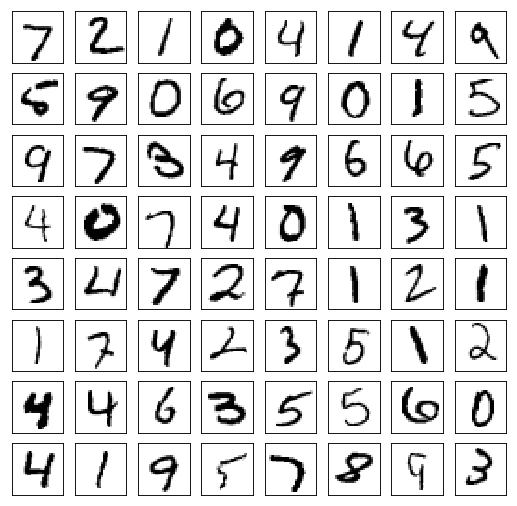

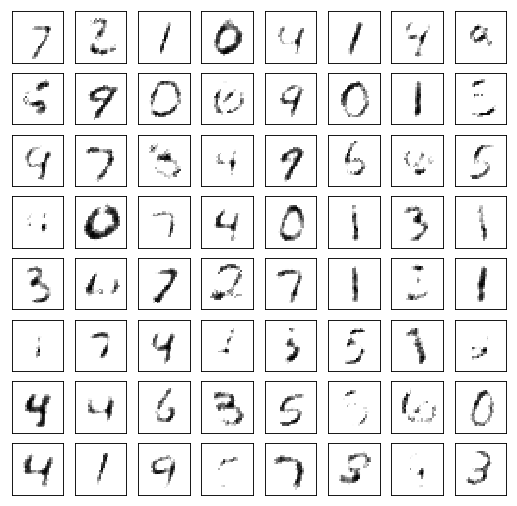

In [24]:
plot_mnist_2(data.data.numpy(), (8, 8))
plot_mnist_2(to_plot, (8, 8))

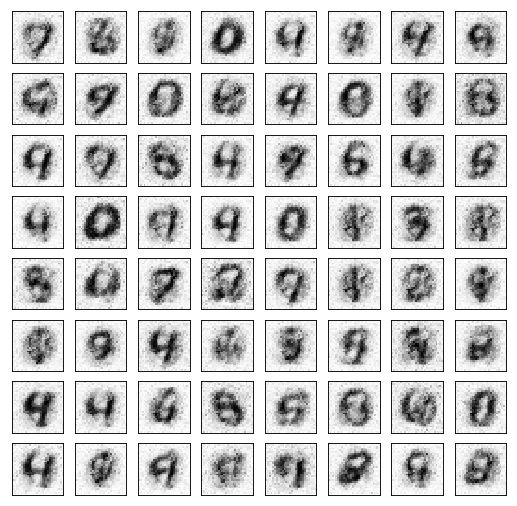

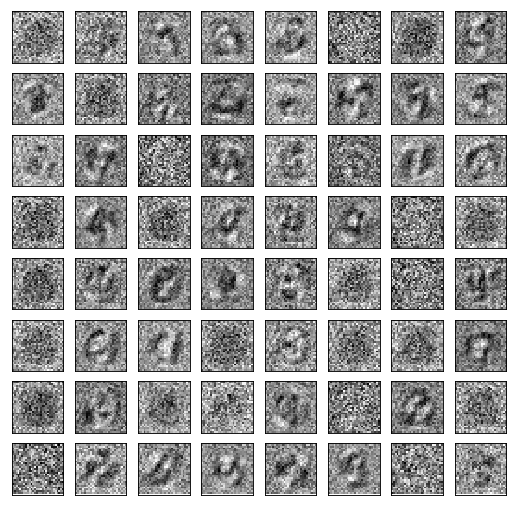

In [25]:
plot_mnist_2(f_to_plot, (8, 8))
plot_mnist_2(dec_to_plot, (8, 8))

Визуализация

### VAE

In [ ]:
root_folder = 'Conv_VAE_log_results_1'
fixed_folder = root_folder + '/Fixed_results'
AE_folder = root_folder + '/VAE_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(AE_folder)

mnist_tanh = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((50, 2))
fixed_data, fixed_target = next(iter(test_loader))

In [ ]:
from models.VAE import VAE

models = {'VAE10': VAE(2, 0.005, batchnorm=False, dropout=False, optim_type='Adam', lr=1e-4)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

Обучим полученную нейросеть:

In [ ]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()

        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)

        else:
            batch_idx += 1
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.4f}'.format(k, m._loss.item()) for k, m in models.items()])
            if log is not None:
                for k in models:
                    log[k].append((models[k]._loss,))
            print(line + losses)


In [ ]:
def test(models, loader, epoch, log=None):
    test_size = len(loader)
    test_reconstruction_loss = {k: 0. for k in models}
    test_KL_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                m.loss(output[k], data)
                test_reconstruction_loss[k] += m._loss.item()
                test_KL_loss[k] += m.KLD.item()

    for k in models:
        test_reconstruction_loss[k] /= test_size
        test_KL_loss[k] /= test_size
    report = 'Test losses: ' + ' '.join(['{}: {:.4f}/{:.4f}'.format(k,
                                                                    test_reconstruction_loss[k],
                                                                    test_KL_loss[k]) for k in models])
    for k in models:
        if log is not None:
            log[k].append((test_reconstruction_loss[k], test_KL_loss[k]))
        with torch.no_grad():
            ae_data = models[k](fixed_data).data.numpy()
            fixed_gen = models[k].decode(fixed_z).data.numpy()
            plot_mnist_4(ae_data, (5, 10), True, AE_folder + '/%s_%03d.png' % (k, epoch))
            plot_mnist_4(fixed_gen, (5, 10), True, fixed_folder + '/%s_%03d.png' % (k, epoch))
    print(report)


In [ ]:
for epoch in range(1, 31):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, epoch, test_log)

In [ ]:
d0 = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
batch = d0.sample(sample_shape=torch.Size([100]))

In [ ]:
with torch.no_grad():
    fixed_gen = models['VAE10'].decode(batch.sort(dim=0)[0]).data.numpy()
    plot_mnist_4(fixed_gen, (10, 10), True, "./123.png")

### GAN

In [ ]:
root_folder = 'FC_GAN_results'
fixed_folder = root_folder + '/Fixed_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)

In [ ]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [ ]:
lr = 0.0001
prior_size = 100
train_epoch = 1000
batch_size = 250
count_class = 10
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((batch_size, 100))

In [ ]:
from models.GAN import FullyConnected

G = FullyConnected([prior_size+count_class, 256, 512, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh())
D = FullyConnected([28*28+count_class, 1024, 512, 256, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True)

G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [ ]:
train_log = {'G': [], 'D': []}
test_log = {'G': [], 'D': []}

In [ ]:
batch_zeros = torch.zeros((batch_size, 1))
batch_ones = torch.ones((batch_size, 1))

In [ ]:
def train(epoch, G, D, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        # train D
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, prior_size))
        fake_pred = D(G(z, target), target)
        true_pred = D(data, target)
        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        D_loss = 0.5*(fake_loss + true_loss)
        
        D_loss.backward()
        D_optimizer.step()
        
        # train G
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, prior_size))
        fake_pred = D(G(z, target), target)
        G_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        
        G_loss.backward()
        
        G_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
        print(line + losses)
        log['G'].append(G_loss.item())
        log['D'].append(D_loss.item())


In [ ]:
def test(G, D, loader, epoch, log=None):
    test_size = len(loader)
    G_loss = 0.
    D_loss = 0.
    test_loss = {'G': 0., 'D': 0.}
    with torch.no_grad():
        for data, target in loader:
            z = torch.randn((batch_size, prior_size))
            fake_pred = D(G(z, target), target)
            true_pred = D(data, target)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            G_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
    
    G_loss /= test_size
    D_loss /= test_size

    fixed_gen = G(fixed_z, target).data.numpy().reshape(batch_size, 1, 28, 28)
    plot_mnist_4(fixed_gen, (10, 25), True, fixed_folder + '/%03d.png' % epoch)
    report = 'Test losses. G: {:.4f}, D: {:.4f}'.format(G_loss, D_loss)
    print(report)


In [ ]:
for epoch in range(1, 31):
    G.train()
    D.train()
    train(epoch, G, D, train_log)
    G.eval()
    D.eval()
    test(G, D, valid_loader, epoch, test_log)

### CAAE

In [ ]:
root_folder = 'FC_CAAE_results_'
fixed_folder = root_folder + '/Fixed_results/'
recon_folder = root_folder + '/Recon_results/'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(recon_folder)

In [ ]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
                lambda x: x.to(device)
           ])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

lr = 0.0001
prior_size = 10
train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((10, prior_size)).repeat((1,10)).view(-1, prior_size).to(device)
fixed_z_label = to_onehot(torch.tensor(list(range(10))).repeat((10)), 10).to(device)
fixed_data, fixed_label = next(iter(test_loader))
fixed_data = fixed_data[:100].to(device)
fixed_label = to_onehot(fixed_label[:100], 10).to(device)

In [ ]:
data, label = next(iter(train_loader))

In [ ]:
from models.CAAE import FullyConnected

Enc = FullyConnected([28*28, 1024, 1024, prior_size], activation_fn=nn.LeakyReLU(0.2), flatten=True, device=device)
Dec = FullyConnected([prior_size+10, 1024, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh(), device=device)
Disc = FullyConnected([prior_size+10, 1024, 1024, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), device=device)

Enc_optimizer = optim.Adam(Enc.parameters(), lr=lr)
Dec_optimizer = optim.Adam(Dec.parameters(), lr=lr)
Disc_optimizer = optim.Adam(Disc.parameters(), lr=lr)

In [ ]:
train_log = {'E': [],'AE': [], 'D': []}
test_log = {'E': [],'AE': [], 'D': []}

In [ ]:
batch_zeros = torch.zeros((batch_size, 1)).to(device)
batch_ones = torch.ones((batch_size, 1)).to(device)

In [ ]:
def train(epoch, Enc, Dec, Disc, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, label) in enumerate(train_loader):
        label = to_onehot(label, 10, device)
        # train D
        Enc.zero_grad()
        Disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size)).to(device)
        z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10, device)

        fake_pred = Disc(Enc(data), label)
        true_pred = Disc(z, z_label)

        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        Disc_loss = 0.5*(fake_loss + true_loss)
        
        Disc_loss.backward()
        Disc_optimizer.step()
        
        # train AE
        Enc.zero_grad()
        Dec.zero_grad()
        Disc.zero_grad()
        
        z = torch.randn((batch_size, prior_size))
        z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10)
        
        latent = Enc(data)
        reconstructed = Dec(latent, label).view(-1, 1, 28, 28)
        fake_pred = Disc(latent, label)
        
        Enc_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        AE_loss = F.mse_loss(reconstructed, data)
        G_loss = AE_loss + Enc_loss
        
        G_loss.backward()
        Dec_optimizer.step()
        Enc_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(Enc_loss.item(), AE_loss.item(), Disc_loss.item())
        print(line + losses)
        log['E'].append(Enc_loss.item())
        log['AE'].append(AE_loss.item())
        log['D'].append(Disc_loss.item())

In [ ]:
def test(Enc, Dec, Disc, loader, epoch, log=None):
    test_size = len(loader)
    E_loss = 0.
    AE_loss = 0.
    D_loss = 0.
    test_loss = {'E': 0., 'AE': 0., 'D': 0.}
    with torch.no_grad():
        for data, label in loader:
            label = to_onehot(label, 10, device)
            z = torch.randn((batch_size, prior_size)).to(device)
            z_label = to_onehot(np.random.randint(0, 10, (batch_size)), 10, device)
            latent = Enc(data)
            reconstructed = Dec(latent, label).view(-1, 1, 28, 28)
            fake_pred = Disc(latent, label)
            true_pred = Disc(z, z_label)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            E_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
            AE_loss += F.mse_loss(reconstructed, data)
            
        E_loss /= test_size
        D_loss /= test_size
        AE_loss /= test_size

        fixed_gen = Dec(fixed_z, fixed_z_label).cpu().data.numpy().reshape(100, 1, 28, 28)
        plot_mnist(fixed_gen, (10, 10), True, fixed_folder + '%03d.png' % epoch)
        fixed_reconstruction = Dec(Enc(fixed_data), fixed_label).cpu().data.numpy().reshape(100, 1, 28, 28)
        plot_mnist(fixed_reconstruction, (10, 10), True, recon_folder + '%03d.png' % epoch)
        
    report = 'Test losses. E: {:.4f}, AE: {:.4f}, D: {:.4f}'.format(E_loss, AE_loss, D_loss)
    print(report)

In [ ]:
for epoch in range(1, 1001):
    Enc.train()
    Dec.train()
    Disc.train()
    train(epoch, Enc, Dec, Disc, train_log)
    Enc.eval()
    Dec.eval()
    Disc.eval()
    test(Enc, Dec, Disc, valid_loader, epoch, test_log)

In [ ]:
Enc.eval()
Dec.eval()
Disc.eval()
test(Enc, Dec, Disc, valid_loader, epoch, test_log)

## Results

## Conclusion